### Preprocessing

#### Filter and Download Data

In [0]:
# Aux Functions
import collections

def get_iterable(x):
    if isinstance(x, collections.Iterable):
        return x
    else:
        return (x,)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin((np.abs(array - value)))
    return array[idx]

def has_diagnosis(list_of_diag,x):
    return [True if any(j in i for j in get_iterable(list_of_diag)) \
            else False for i in get_iterable(temp_diagnosis.dx1.values)]



In [0]:
# load data
grand = pd.read_csv('../scans_Oasis.csv') # all scans
g_diagnosis = pd.read_csv('../diagnosis_Oasis.csv') .dropna(subset=['dx1']) #"grand" diagnosis 
participants = g_diagnosis.Subject.unique() #possible IDs


# Create "master list"
scan_IDs=[]
diag=[]
AD_MRI_Master = {}

for sub in participants:
      
    
    temp_diagnosis=g_diagnosis.loc[g_diagnosis.Subject==sub,['dx1','ageAtEntry']]
    
    
    temp_scans=grand.loc[grand.Subject==sub,['MR ID','Age','Scans']]
    # matching AD scan, nearest diagnosis
    #print(sub)
    if np.any(has_diagnosis(['AD','DAT'],temp_diagnosis.dx1.values)):
        AD+=1
        AD_MRI_Master[sub]={}
        
        first=has_diagnosis(['AD','DAT'],temp_diagnosis)
        age_diag = temp_diagnosis.loc[first,'ageAtEntry'].values[0]
        age_scan = find_nearest(temp_scans.Age.values,age_diag)
        scan_ID = temp_scans.loc[temp_scans.Age==age_scan,['MR ID']].values[0][0]    
        #print(sub,scan_ID)
        scan_IDs.append(scan_ID)
        diag.append('AD')
        AD_MRI_Master[sub]['subject']=sub
        AD_MRI_Master[sub]['age'] = age_scan
        AD_MRI_Master[sub]['diagnosis']='AD'
        AD_MRI_Master[sub]['scan_ID'] = scan_ID
        
        
    elif np.all(has_diagnosis(['normal','.'],temp_diagnosis.dx1.values)):
        
        CN+=1
        AD_MRI_Master[sub]={}
            
        first=has_diagnosis(['normal','.'],temp_diagnosis)
        age_diag = temp_diagnosis.loc[first,'ageAtEntry'].values[0]
        age_scan = find_nearest(temp_scans.Age.values,age_diag)
        scan_ID = temp_scans.loc[temp_scans.Age==age_scan,['MR ID']].values[0][0]
        #print(sub,scan_ID)
        scan_IDs.append(scan_ID)
        diag.append('CN')
        AD_MRI_Master[sub]['subject']=sub
        AD_MRI_Master[sub]['age'] = age_scan
        AD_MRI_Master[sub]['diagnosis']='CN'
        AD_MRI_Master[sub]['scan_ID'] = scan_ID
    else:
        #print(sub,temp_diagnosis.dx1)
        Other+=1

In [0]:
# Create scan IDs (only) csv:
sids= pd.DataFrame(scan_IDs)
sids.to_csv("scan_IDs.csv",header=False,index=False)

In [0]:
# Download data using script:
#! sh download_oasis_scans.sh scan_IDs.csv ./DATA dbrennan T1

# This downloads all the data for scan IDs in "sids"/"scan_IDs.csv" to a folder called DATA

#### Preprocess Data

In [0]:
# if you need ants registration package:

# !pip install antspyx

In [0]:
import numpy as np
import pandas as pd
import ants

import glob
import re

In [0]:
paths=[]

data_dir = '~/data'
mni_path = '~/MNI152_T1_1mm.nii.gz'

subject_pattern = re.compile('OAS\d{5}')
paths=glob.glob(data_dir+'/**/*.nii*',recursive=True)
subs = [subject_pattern.findall(i)[0] for i in paths]
subs = list(np.unique(subs))

mni = ants.image_read(mni_path,pixeltype='unsigned int')

In [0]:
# auxilliary functions

import collections
def get_iterable(x):
    if isinstance(x, collections.Iterable):
        return x
    else:
        return (x,)
def my_minmax(z):
    return (z-np.min(z))/(np.max(z)-np.min(z))


def start_from(my_list,start):
    l=[i for i in my_list.keys()]
    start_ind = [num for num,j in enumerate(l) if j == start][0]
    return l[start_ind:]


for sub in start_from(AD_MRI_Master,'OAS30001'): #can start from any participant if preproc gets interrupted, etc
#for sub in ('OAS30599',):
    
    sID = AD_MRI_Master[sub]['scan_ID']
    T1_paths = glob.glob('DATA/'+sID+'/**/*T1w*nii*')
    try:
        T1_path = get_iterable(T1_paths)[0]
    except:
        print(sub,': cant find T1!')

    moving = ants.image_read(T1_path)
    #fit transformation
    transform = ants.registration(fixed=mni,moving=moving,type_of_transform='SyN')
    out_data= AD_MRI_Master[sub] #copies all demographic data: age, diagnosis etc.
    # makes new dict entry, "image" which contains T1, after applying transformation:
    out_data['image']=ants.apply_transforms(fixed=mni,moving=moving,
                                            transformlist=transform['fwdtransforms']).resample_image((120,160,120),use_voxels=True)
    out_data['image']=my_minmax(out_data['image'].numpy()) #squash values to 0:1
    
    # dumps new dicts into foldr called "processed" which contains all of the data ready for analysis
    with open('PROCESSED/'+ sub +'_data','wb') as f:
        pickle.dump(out_data, f)
    


#### QA with "QA.py"

After all data is processed, do QA with "QA.py", which will display slices of image and slices of MNI.

Ensure they are aligned, and respond "g" if good, and "b" if bad. Response is recorded and QA list updated:

In [0]:
# ! python QA.py

# after going through and reprocessing bad images, check QA again with:
# ! python QA_update.py

### Finally, data is ready for deep learning!


#### Import Libraries and Mount Data

In [0]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings
import tensorflow as tf
import random
import scipy
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, \
        Flatten, Conv3DTranspose, UpSampling3D, Reshape, Input, concatenate
from tensorflow.keras.regularizers import l1_l2
from google.colab import drive


In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
warnings.filterwarnings('ignore')

In [11]:
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


#### Set Options

In [0]:
#-- Experimental options --#

#-- Dropout; values tested: 0.0, 0.5, 0.8
dropout_rate = 0.8

#-- With or without inception block 
with_ib = False

#-- With or without an autoencoder
with_ae = True

#-- Number of Epochs
n_epochs = 2 #50

#-- Number of nodes in first dense layer of classifier; values tested: 1024, 256
n_nodes_1st = 1024

#-- Number of nodes in second dense layer of classifier; values tested: 64, 128
n_nodes_2nd = 64

#-- Classifier output layer activation; values tested: softmax, sigmoid
output_act = 'softmax'

# According to Nature paper (Oh et. al.), l1 and l2 values of 10e-4 
#   performed the best from experimentation with 0.01, 0.001, 0.0001, 0.00001 
#   values.
#-- L1 regularization option in inception block; off at 0
l1_value = 0

#-- L2 regularization option in inception block; off at 0
l2_value = 0



#-- Fairly static options for consistent experimentation --#

#-- File path to pickled master sheet
master_file = '/content/drive/My Drive/AD_MRI/AD_MRI_Master'

#-- Directory path to preprocessed images
processed_dir = '/content/drive/My Drive/AD_MRI/PROCESSED/'

#-- Initial split (percent validation from original train)
test_size_1st = 0.10

#-- Second split of (percent test from initial train split)
test_size_2nd = 0.10

#-- Input dimensions for ventricles_only=True; otherwise (120, 160, 120, 1)
input_dim = (120, 160, 16, 1)

#-- Filters for inception block in the specified branch order: 
#       [branch_1x1x1, branch_3x3x3, branch_double_3x3x3, branch_maxpool_3x3x3]
filter_operation = [10, 10, 10, 10]

#-- Inception model summary view setting for positions to minimize truncation
four_cols = [.35, .64, .71, 1.]


#### Create Train/Test Subset

In [0]:
#%cd /content/drive/My Drive/AD_MRI

def create_master_sheet(filepath=master_file):
    # Load list of records
    with open(filepath, 'rb') as f:
        master_list = pickle.load(f)
        
    master_sheet = pd.DataFrame.from_dict(master_list, orient='index')
    display(master_sheet.head())

    return master_sheet


def split_data(master_sheet):
    # Split into train, validation, test
    train_list, val_list, train_label, val_label = \
            train_test_split(master_sheet.subject.values, 
                            master_sheet.diagnosis.values, 
                            random_state = 1337, 
                            test_size=test_size_1st)
            
    train_list, test_list, train_label, test_label = \
            train_test_split(train_list, 
                            train_label, 
                            random_state = 0, 
                            test_size=test_size_2nd)
            
    return train_list, train_label, val_list, val_label, test_list, test_label

def check_split(train_list, train_label, val_list, val_label, test_list, test_label):

    # Check for ratios of AD to NC to be consistent among sets
    AD_count = 0
    for lab in train_label:
        if lab == 'AD':
            AD_count +=1
    print('train_ratio AD: ', round(AD_count/len(train_label), 3))

    AD_count = 0
    for lab in val_label:
        if lab == 'AD':
            AD_count +=1
    print('val_ratio AD: ', round(AD_count/len(val_label), 3))

    AD_count = 0
    for lab in test_label:
        if lab == 'AD':
            AD_count +=1
    print('test_ratio AD: ', round(AD_count/len(test_label), 3))

    print('\nNumber of records\ntrain:', len(train_list), 
        '\nvalidation:', len(val_list), '\ntest:', len(test_list))



#### Create Generator

In [0]:
def labels_to_categorical(labels):
    le = LabelEncoder()
    le.fit(["CN", "AD"])
    num_lab = to_categorical(le.transform(labels), num_classes=2)
    return num_lab


def my_minmax(z):
    return (z-np.min(z)) / (np.max(z)-np.min(z))


class MyDataGenerator(Sequence):
    """Generates data for Keras Sequence based data generator. 
    Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, processed_dir=processed_dir, augment=False, 
                 to_fit=True, batch_size=32, dim=(120, 160, 120, 1),
                 n_classes=2, shuffle=True, with_ib=False, with_ae=True, 
                 ventricles_only=True, slice_start=50, slice_end=66, 
                 sample_weight=None):
        """Initialization
        :param list_IDs: list of all 'label' PATHS
        :param processed_dir: path to directory of processed images
        :param augment: True to augment data with random image rotations
        :param to_fit: True to return X, y and w, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        :param with_ib: True to include inception block(s)
        :param with_ae: True to also run decoder and autoencoder, 
                        False to run encoder/classifier only
        :param ventricles_only: True to reduce dimensions to relevant slice
        :param slice_start: starting index for ventricles_only=True
        :param slice_end: ending index for ventricles_only=True
        :param sample_weight: weights to address class imbalance if to_fit=True
        """
        self.list_IDs = list_IDs
        self.processed_dir = processed_dir
        self.augment = augment
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.with_ib = with_ib
        self.with_ae = with_ae
        self.ventricles_only = ventricles_only
        self.on_epoch_end()
        self.slice_start = slice_start
        self.slice_end = slice_end
        if self.ventricles_only == False:
            self.slice_size = 120
        else:
            self.slice_size = slice_end - slice_start
        self.sample_weight = sample_weight


    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index 
                               * self.batch_size:(index + 1) 
                               * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        X, y = self._load_data(list_IDs_temp)
        X = my_minmax(np.float32(X))
        if self.ventricles_only == True:
          X = X[:, :, :, self.slice_start:self.slice_end, :]
        w_temp = np.asarray([self.sample_weight[k] for k in indexes])
        if self.to_fit:
            if self.with_ae:
                y = {'classifier': y, 'decoder': X}
                w = {'classifier': w_temp,
                    'decoder':np.ones(np.shape(X))}
            else:
                w = w_temp
            return X, y, w

        else:
            return X


    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def _load_data(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # start X
            with open(self.processed_dir+ID+'_data','rb') as f:
                data = pickle.load(f)
                
            # third dimension = 120, error using self.slice_size for value 16
            x_reshape= np.reshape(data['image'], (120, 160, 120, 1))
            if self.augment == True:
                x_reshape = scipy.ndimage.rotate(x_reshape, 
                                axes=random.choice([(0, 1), (0, 2), (1, 2)]), 
                                angle=random.choice([360-15, 15,0]), 
                                reshape=False)
            X[i,] = x_reshape
            
            #start y
            y[i,] = labels_to_categorical([data['diagnosis']])

        return X, y

    

In [0]:
def check_gen(train_label, test_list):

    print(labels_to_categorical(["CN"]))

    balancing_weights = class_weight.compute_sample_weight('balanced', 
                                                           train_label)
    print(balancing_weights[0], train_label[0])
    print(balancing_weights[1], train_label[1])

    # # usage:
    # mdg = MyDataGenerator(test_list, processed_dir=PROCESSED_DIR, to_fit=False, 
    #                       augment=True, sample_weight=balancing_weights, 
    #                       batch_size=2)

    # X, y, weights = mdg.__getitem__(0) #without .__getitem__ obviously

    # print('X:', X, '\ny:', y, '\nweights:', weights)


#### Create Inception Block

In [0]:
def inception_module(input, filter_operation=filter_operation, 
                     l1_value=l1_value, l2_value=l2_value):
    """
    filter_operation is a list of inception operations for:
        1x1x1 kernel, 
        1x1x1 then 3x3x3 kernels, 
        1x1x1 then 3x3x3 then 3x3x3 kernels, 
        and 3x3x3 maxpooling then 1x1x1 kernels, 
            respectively.
    """
    # Branch A
    branch_1x1x1 = Conv3D(filter_operation[0], kernel_size=(1, 1, 1), 
                          activation='relu', padding='same', 
                          kernel_regularizer=l1_l2(l1_value, l2_value), 
                          name='Branch_A_1x1x1')(input)

    # Branch B
    branch_3x3x3_initial = Conv3D(filter_operation[1], kernel_size=(1, 1, 1), 
                                  activation='relu', padding='same', 
                                  kernel_regularizer=l1_l2(l1_value, l2_value), 
                                  name='Branch_B_1x1x1')(input)
    branch_3x3x3 = Conv3D(filter_operation[1], kernel_size=(3, 3, 3), 
                          activation='relu', padding='same', 
                          kernel_regularizer=l1_l2(l1_value, l2_value), 
                          name='Branch_B_3x3x3')(branch_3x3x3_initial)

    # Branch C
    branch_double_3x3x3_initial = Conv3D(filter_operation[2], 
                                         kernel_size=(1, 1, 1), 
                                         activation='relu', padding='same', 
                                         kernel_regularizer=l1_l2(l1_value, 
                                                                  l2_value), 
                                         name='Branch_C_1x1x1')(input)
    branch_double_3x3x3_middle = Conv3D(filter_operation[2], 
                                        kernel_size=(3, 3, 3), 
                                        activation='relu', padding='same', 
                                        kernel_regularizer=l1_l2(l1_value, 
                                                                 l2_value), 
                                        name='Branch_C_1st_3x3x3')\
                                        (branch_double_3x3x3_initial)
    branch_double_3x3x3 = Conv3D(filter_operation[2], kernel_size=(3, 3, 3), 
                                 activation='relu', padding='same', 
                                 kernel_regularizer=l1_l2(l1_value, l2_value), 
                                 name='Branch_C_2nd_3x3x3')\
                                 (branch_double_3x3x3_middle)

    # Branch D
    branch_maxpool_3x3x3_initial = MaxPool3D(pool_size=(3, 3, 3), 
                                             strides=(1, 1, 1), padding='same', 
                                             name='Branch_D_3x3x3_maxpool')\
                                             (input)
    branch_maxpool_3x3x3 = Conv3D(filter_operation[3], kernel_size=(1, 1, 1), 
                                  activation='relu', padding='same', 
                                  kernel_regularizer=l1_l2(l1_value, l2_value), 
                                  name='Branch_D_1x1x1')\
                                  (branch_maxpool_3x3x3_initial)
    
    # Merge branches
    modules = [branch_1x1x1, branch_3x3x3, branch_double_3x3x3, 
               branch_maxpool_3x3x3]
    merged_module = concatenate(modules, name='Inception_Merged')
    
    return merged_module
    


#### Build Encoder

In [0]:
def build_encoder(input_dim=input_dim, with_ib=with_ib, dropout_rate=dropout_rate):
    '''
    '''
    input_img = Input(shape=input_dim, name='Input')
    print('\ninput shape:', input_img.shape)

    x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
            name='Convolution_1')(input_img)
    x = MaxPool3D((2, 2, 2), name='MaxPooling_1')(x)
    x = Dropout(dropout_rate, name='DropOut_1')(x)

    x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
            name='Convolution_2')(x)
    x = MaxPool3D((2, 2, 2), name='MaxPooling_2')(x)
    x = Dropout(dropout_rate, name='DropOut_2')(x)

    if with_ib:
        x = inception_module(x, filter_operations)
    else:
        x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
                name='Convolution_3')(x)
    x = MaxPool3D((2, 2, 2), name='MaxPooling_3')(x)
    x = Dropout(dropout_rate, name='DropOut_3')(x)

    encoded = x
    encoded_shape = K.int_shape(encoded)
    print('output shape:', encoded_shape, '\n')

    encoder = Model(input_img, encoded, name='encoder')

    if with_ib:
        encoder.summary(positions=four_cols) 
    else:
        encoder.summary()
    
    return encoder, encoded_shape



#### Build Decoder

In [0]:
def build_decoder(encoder, encoded_shape, 
                  with_ib=with_ib, dropout_rate=dropout_rate):
    '''
    used when with_ae=True
    '''
    encoded_input = Input(shape=(encoded_shape[1],encoded_shape[2], 
                                encoded_shape[3], encoded_shape[4],), 
                        name='Encoded')
    print('\ninput shape:', encoded_input.shape)

    x = encoded_input

    if with_ib:
        x = inception_module(x, filter_operations)
    else:
        x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                            name='Convolution_3')(x)
    x = UpSampling3D((2, 2, 2), name='UpSampling_3')(x)
    x = Dropout(dropout_rate, name='DropOut_3')(x)

    x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                        name='Convolution_2')(x)
    x = UpSampling3D((2, 2, 2), name='UpSampling_2')(x)
    x = Dropout(dropout_rate, name='DropOut_2')(x)

    x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                        name='Convolution_1')(x)
    x = UpSampling3D((2, 2, 2), name='UpSampling_1')(x)
    x = Dropout(dropout_rate, name='DropOut_1')(x)

    x = Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same', 
                            name='Output')(x)

    decoded = x
    print('output shape:', K.int_shape(decoded), '\n')

    decoder = Model(encoded_input, decoded, name='decoder')

    if with_ib:
        decoder.summary(positions=four_cols)
    else:
        decoder.summary()

    return decoder



#### Build Classifier

In [0]:
def build_classifier(encoded, encoded_shape, n_nodes_1st=n_nodes_1st, 
                     n_nodes_2nd=n_nodes_2nd, output_act=output_act):
    '''
    '''
    encoded_input = Input(shape=(encoded_shape[1], encoded_shape[2], 
                                encoded_shape[3], encoded_shape[4],), 
                        name='Encoded')

    y = encoded_input

    y = Flatten(name='Flatten')(y)
    y = Dense(n_nodes_1st, activation='selu', name='SELU_1')(y)
    y = Dense(n_nodes_2nd, activation='selu', name='SELU_2')(y)
    y = Dense(2, activation=output_act, name='Prediction')(y)

    pred = y

    classifier = Model(encoded_input, pred, name='classifier')
    classifier.summary()

    return classifier



#### Build Autoencoder

In [0]:
def build_autoencoder(encoder, decoder, classifier, input_dim=input_dim):
    '''
    '''
    input_img = Input(shape=input_dim, name='Input')
    autoencoder = Model(inputs=input_img, 
                            outputs=[decoder(encoder(input_img)), 
                                    classifier(encoder(input_img))],
                    name='autoencoder')

    if with_ib:
        autoencoder.summary(positions=four_cols)
    else:
        autoencoder.summary()

    return autoencoder



#### Run Pipeline

In [21]:
#-- Set options above and run pipeline

master_sheet = create_master_sheet()

train_list, train_label, val_list, val_label, test_list, test_label = \
    split_data(master_sheet)

#-- optional check
check_split(train_list, train_label, val_list, val_label, test_list, test_label)

#-- optional check
check_gen(train_label, test_list)

encoder, encoded_shape = build_encoder()
classifier = build_classifier(encoder, encoded_shape)

if with_ae:
    decoder = build_decoder(encoder, encoded_shape)
    autoencoder = build_autoencoder(encoder, decoder, classifier)



,subject,age,diagnosis,scan_ID
OAS30001,OAS30001,65.0,CN,OAS30001_MR_d0129
OAS30002,OAS30002,68.0,CN,OAS30002_MR_d0371
OAS30003,OAS30003,60.0,CN,OAS30003_MR_d0558
OAS30004,OAS30004,58.0,CN,OAS30004_MR_d1101
OAS30005,OAS30005,48.0,CN,OAS30005_MR_d0143


train_ratio AD:  0.367
val_ratio AD:  0.367
test_ratio AD:  0.371

Number of records
train: 793 
validation: 98 
test: 89
[[0. 1.]]
1.3625429553264605 AD
0.7898406374501992 CN

input shape: (None, 120, 160, 16, 1)
output shape: (None, 15, 20, 2, 10) 

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 16, 1)] 0         
_________________________________________________________________
Convolution_1 (Conv3D)       (None, 120, 160, 16, 10)  280       
_________________________________________________________________
MaxPooling_1 (MaxPooling3D)  (None, 60, 80, 8, 10)     0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 60, 80, 8, 10)     0         
_________________________________________________________________
Convolution_2 (Conv3D)       (None, 60, 80, 8, 10)     2710      
_____

#### Build Classifier Branch

In [0]:
losses = {'decoder':'binary_crossentropy', 
          'classifier':'categorical_crossentropy'}
metrics= {'decoder':'mae', 'classifier':[ \
                                            'acc',
                                            tf.keras.metrics.Precision(), 
                                            tf.keras.metrics.Recall(),
                                            tf.keras.metrics.FalseNegatives(), 
                                            tf.keras.metrics.FalsePositives()]}
loss_weights={'decoder':0.5,'classifier':0.5}

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(\
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.90,
    staircase=True)

autoencoder.compile(optimizer='adam', 
                         loss=losses,
                         loss_weights = loss_weights,
                         metrics=metrics)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath=\
        '/content/drive/My Drive/AD_MRI/outputs_AC/\
        pipeline_0523.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs_AC'),
]

In [0]:
balancing_weights = class_weight.compute_sample_weight('balanced', 
                                                       train_label)
balancing_weights_test = class_weight.compute_sample_weight('balanced', 
                                                            test_label)

In [0]:
train_generator = MyDataGenerator(train_list, processed_dir, to_fit=True, 
                                  augment=True, batch_size=32, 
                                  sample_weight=balancing_weights)
test_generator = MyDataGenerator(test_list, processed_dir, batch_size=32, 
                                 sample_weight=balancing_weights_test)

#### Run Model

In [25]:
history_pipeline = autoencoder.fit_generator(generator=train_generator, 
                                              epochs=n_epochs, 
                                              validation_data=test_generator, 
                                              shuffle=True, 
                                              callbacks = my_callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
24/24 [==============================] - 601s 25s/step - loss: 2.0474 - decoder_loss: 0.9890 - classifier_loss: 3.1058 - decoder_mae: 0.2583 - classifier_acc: 0.5221 - classifier_precision: 0.5221 - classifier_recall: 0.5221 - classifier_false_negatives: 367.0000 - classifier_false_positives: 367.0000 - val_loss: 0.6992 - val_decoder_loss: 0.6737 - val_classifier_loss: 0.7248 - val_decoder_mae: 0.2817 - val_classifier_acc: 0.4219 - val_classifier_precision: 0.4219 - val_classifier_recall: 0.4219 - val_classifier_false_negatives: 37.0000 - val_classifier_false_positives: 37.0000
Epoch 2/2
24/24 [==============================] - 382s 16s/step - loss: 0.7136 - decoder_loss: 0.6608 - classifier_loss: 0.7665 - decoder_mae: 0.1905 - classifier_acc: 0.5000 - classifier_precision: 0.5000 - classifier_recall: 0.5000 - classifier_false_negatives: 384.0000 - classifier_false_positives: 384.0000 - val_loss: 0.66

#### Analyze Results

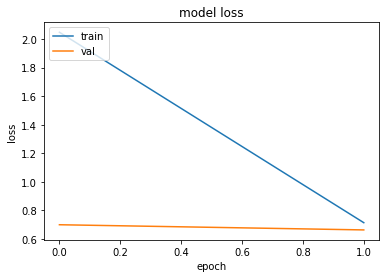

In [29]:
if with_ae:
    autoencoder.save('autoencoder_pipeline.h5')
else:
    classifier.save('classifier_pipeline.h5')
with open('/content/drive/My Drive/AD_MRI/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history_pipeline.history, file_pi)
plt.plot(history_pipeline.history['loss'])
plt.plot(history_pipeline.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
history_pipeline.history.keys()

dict_keys(['loss', 'decoder_loss', 'classifier_loss', 'decoder_mae', 'classifier_acc', 'classifier_precision', 'classifier_recall', 'classifier_false_negatives', 'classifier_false_positives', 'val_loss', 'val_decoder_loss', 'val_classifier_loss', 'val_decoder_mae', 'val_classifier_acc', 'val_classifier_precision', 'val_classifier_recall', 'val_classifier_false_negatives', 'val_classifier_false_positives'])

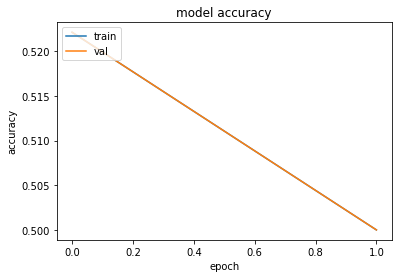

In [31]:
plt.plot(history_pipeline.history['classifier_acc'])
plt.plot(history_pipeline.history['classifier_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

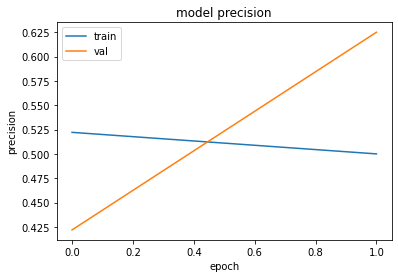

In [39]:
plt.plot(history_pipeline.history['classifier_precision'])
plt.plot(history_pipeline.history['val_classifier_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
balancing_weights_val = class_weight.compute_sample_weight('balanced', 
                                                           val_label)
val_generator = MyDataGenerator(val_list, processed_dir, to_fit=False, 
                                batch_size=2, 
                                sample_weight=balancing_weights_val)
if with_ae:
    pred = autoencoder.predict_generator(val_generator)
else:
    pred = classifier.predict_generator(val_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [34]:
from sklearn.metrics import classification_report, accuracy_score

print("acc: ", accuracy_score(labels_to_categorical(val_label), 
                              np.round(pred[1])))
print(classification_report(labels_to_categorical(val_label), 
                            np.round(pred[1])))

acc:  0.6326530612244898
              precision    recall  f1-score   support

           0       0.50      0.06      0.10        36
           1       0.64      0.97      0.77        62

   micro avg       0.63      0.63      0.63        98
   macro avg       0.57      0.51      0.43        98
weighted avg       0.59      0.63      0.52        98
 samples avg       0.63      0.63      0.63        98



In [0]:
with open('/content/drive/My Drive/AD_MRI/outputs_AC/trainHistoryDict', 'rb') as file_pi:
    test = pickle.load(file_pi)

In [37]:
test['loss'][-10:]

[0.6932370662689209,
 0.6932371258735657,
 0.6937539577484131,
 0.69427090883255,
 0.6953046321868896,
 0.69427090883255,
 0.6963384747505188,
 0.6937539577484131,
 0.6932372450828552,
 0.6932370662689209]

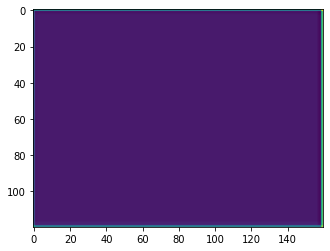

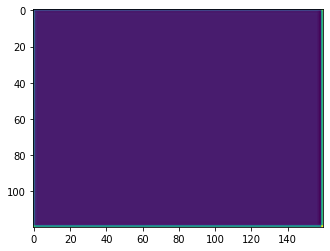

In [38]:
if with_ae:
    plt.imshow(pred[0][2][:,:,15,0])
    plt.show()
    plt.imshow(pred[0][2][:,:,0,0])